In [6]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC

import os
import math
import numpy as np
from PIL import Image
from skimage import exposure, io
import matplotlib.pyplot as plt

import datetime
import json
import re
import fnmatch

from src.globals import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC


In [7]:
BASE_DATA_PATH = "./data/"

data_path = BASE_DATA_PATH + "raw_data/acdc_large/acdc_data2"

In [44]:
def load_video(data_path,experiment_name, position, filename):
    path = data_path + "/" + experiment_name + "/" + position + "/Images/"
    print("loading:", path )
    
    vid = io.imread(path + filename + "phase_contr.tif")    
    print("loaded video with shape:\t",vid.shape)

    vid_npz = np.load(path + filename + "phase_contr_aligned.npy") #['arr_0']
        
    lables = np.load(path + filename + "segm.npz")['arr_0']
    print("loaded lables with shape:\t",lables.shape)
    
    data = np.array([vid, vid_npz ,lables])
    print(data.shape)
    
    return data
    

    



In [45]:
data = load_video(data_path,"F016","Position_4","F016_s04_")


loading: ./data/raw_data/acdc_large/acdc_data2/F016/Position_4/Images/
loaded video with shape:	 (161, 1024, 1024)
loaded lables with shape:	 (161, 1024, 1024)
(3, 161, 1024, 1024)


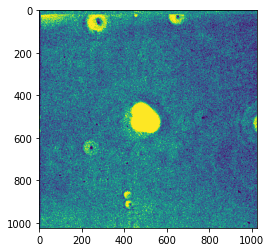

In [52]:

def show_image(ims):
    
    if len(ims.shape) == 2:
        im_cont = exposure.equalize_adapthist(ims)
        plt.imshow(im_cont)
    
    else:
        fig = plt.figure(figsize=(16, 10))

        num_figures = ims.shape[0]
        cols = 4
        rows = int(math.ceil(num_figures/cols))


        for i in range(num_figures):
            im_cont = exposure.equalize_adapthist(ims[i])
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(im_cont)
    
    plt.show()


#experiment_name = "MIA_KC_htb1_mCitrine_labeled"
#position = "Position_3"
#filename = "19-03-2021_KCY050_SCGE_s03_"

#data = load_video(experiment_name, position, filename)
#image = np.flip(data[0][18],0)
image = (np.flip(data[1][18],0) > 1500) + (np.flip(data[2][18],0) > 0)
show_image(image)


In [130]:
ROOT_DIR = '../data/images_and_masks'
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
ANNOTATION_DIR = os.path.join(ROOT_DIR, "annotations")

INFO = {
    "description": "Cell ACDC data in COCO format",
    "url": "",
    "version": "0.1.0",
    "year": 2022,
    "contributor": "Florian Bridges",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "",
        "url": ""
    }
]

CATEGORIES = [
    {
        'id': 0,
        'name': 'cell',
        'supercategory': 'cell',
    }
]

def filter_for_png(root, files):
    file_types = ['*.png']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    files = [os.path.join(root, f) for f in files]
    files = [f for f in files if re.match(file_types, f)]
    
    return files

def filter_for_annotations(root, files, image_filename):
    file_types = ['*.png']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    basename_no_extension = os.path.splitext(os.path.basename(image_filename))[0]
    file_name_prefix = basename_no_extension + '.*'
    files = [os.path.join(root, f) for f in files]
    files = [f for f in files if re.match(file_types, f)]
    files = [f for f in files if re.match(file_name_prefix, os.path.splitext(os.path.basename(f))[0])]

    return files

def main():

    coco_output = {
        "info": INFO,
        "licenses": LICENSES,
        "categories": CATEGORIES,
        "images": [],
        "annotations": []
    }

    image_id = 1
    segmentation_id = 1
    
    # filter for jpeg images
    for root, _, files in os.walk(IMAGE_DIR):
        image_files = filter_for_png(root, files)

        # go through each image
        for image_filename in image_files:
            image = Image.open(image_filename)
            image_info = pycococreatortools.create_image_info(
                image_id, os.path.basename(image_filename), image.size)
            coco_output["images"].append(image_info)

            # filter for associated png annotations
            for root, _, files in os.walk(ANNOTATION_DIR):
                annotation_files = filter_for_annotations(root, files, image_filename)

                # go through each associated annotation
                for annotation_filename in annotation_files:
                    
                    print(annotation_filename)
                    class_id = [x['id'] for x in CATEGORIES if x['name'] in annotation_filename][0]

                    category_info = {'id': class_id, 'is_crowd': 'crowd' in image_filename}
                    binary_mask = np.asarray(Image.open(annotation_filename)
                        .convert('1')).astype(np.uint8)
                    
                    annotation_info = pycococreatortools.create_annotation_info(
                        segmentation_id, image_id, category_info, binary_mask,
                        image.size, tolerance=2)

                    if annotation_info is not None:
                        coco_output["annotations"].append(annotation_info)

                    segmentation_id = segmentation_id + 1

            image_id = image_id + 1

    with open('{}/cell_acdc_coco_ds.json'.format(ROOT_DIR), 'w') as output_json_file:
        json.dump(coco_output, output_json_file)


main()

../data/images_and_masks/annotations/3_234_cell_11.png
../data/images_and_masks/annotations/3_234_cell_14.png
../data/images_and_masks/annotations/3_234_cell_3.png
../data/images_and_masks/annotations/3_234_cell_13.png
../data/images_and_masks/annotations/3_234_cell_4.png
../data/images_and_masks/annotations/3_234_cell_15.png
../data/images_and_masks/annotations/3_234_cell_1.png
../data/images_and_masks/annotations/3_234_cell_8.png
../data/images_and_masks/annotations/3_234_cell_12.png
../data/images_and_masks/annotations/3_234_cell_9.png
../data/images_and_masks/annotations/3_234_cell_17.png
../data/images_and_masks/annotations/3_234_cell_16.png
../data/images_and_masks/annotations/3_234_cell_5.png
../data/images_and_masks/annotations/3_234_cell_10.png
../data/images_and_masks/annotations/1_144_cell_18.png
../data/images_and_masks/annotations/1_144_cell_5.png
../data/images_and_masks/annotations/1_144_cell_14.png
../data/images_and_masks/annotations/1_144_cell_15.png
../data/images_an

/home/florian/GitRepos/segmentationMicroscopy/src/pycococreatortools.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.subtract(contours, 1)


../data/images_and_masks/annotations/0_193_cell_5.png
../data/images_and_masks/annotations/0_139_cell_4.png
../data/images_and_masks/annotations/0_177_cell_13.png
../data/images_and_masks/annotations/0_123_cell_7.png
../data/images_and_masks/annotations/0_196_cell_16.png
../data/images_and_masks/annotations/0_193_cell_9.png
../data/images_and_masks/annotations/0_138_cell_4.png
../data/images_and_masks/annotations/0_183_cell_2.png
../data/images_and_masks/annotations/0_131_cell_2.png
../data/images_and_masks/annotations/0_109_cell_2.png
../data/images_and_masks/annotations/0_157_cell_13.png
../data/images_and_masks/annotations/0_168_cell_12.png
../data/images_and_masks/annotations/0_186_cell_13.png
../data/images_and_masks/annotations/0_114_cell_7.png
../data/images_and_masks/annotations/0_129_cell_1.png
../data/images_and_masks/annotations/0_118_cell_6.png
../data/images_and_masks/annotations/0_189_cell_14.png
../data/images_and_masks/annotations/0_167_cell_14.png
../data/images_and_ma

In [133]:
with open(ROOT_DIR + "/cell_acdc_coco_ds.json") as file:
    data = json.load(file)

{'id': 1,
 'image_id': 1,
 'category_id': 0,
 'iscrowd': 0,
 'area': 526,
 'bbox': [83.0, 31.0, 23.0, 29.0],
 'segmentation': [[99.0,
   59.5,
   89.0,
   59.5,
   82.5,
   50.0,
   82.5,
   39.0,
   91.0,
   30.5,
   98.0,
   33.5,
   105.5,
   44.0,
   104.5,
   53.0,
   99.0,
   59.5]],
 'width': 255,
 'height': 143}

In [1]:
from data2coco import *

In [6]:
filter_for_annotations("./data/dataInCOCO/test/annotations",['0_181_cell_4.png', '0_170_cell_10.png', '0_168_cell_25.png','0_20_cell_4.png','0_200_cell_4.png'],"./data/dataInCOCO/test/images/0_20.png")

0_20.*


['./data/dataInCOCO/test/annotations/0_20_cell_4.png',
 './data/dataInCOCO/test/annotations/0_200_cell_4.png']